# House Prices: Advanced Regression Techniques

This is the Ames Housing dataset. The aim is to predict the sales price for each house. It has 79 explanatory variables describing aspects of residential homes in Ames, Iowa; from height of the basement to the proximity to an east-west railroad. It is a Kaggle competition and is evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price.

In [1]:
%load_ext autoreload
%autoreload 2 
#By using these two lines IPython will import all the latest versions of the modules

%matplotlib inline
#This ensures that the graphs are displayed in the same notebook and not on a seperate GUI

In [2]:
from fastai.imports import *
from fastai.structured import *
import csv

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

In [4]:
set_plot_sizes(12,14,16) 

Importing the training set 'Housing_train.csv' and passing any columns containing dates in a list through the 'parse_dates' parameter.

In [5]:
df_raw = pd.read_csv('Housing_train.csv', low_memory=False,
                     parse_dates=["YearBuilt", "YearRemodAdd"])

In [6]:
columns = list(df_raw.columns)

Displaying the dataset once to make sure that it has been imported properly and to make sure you understand the format, how it's stored, what type of values it holds, etc.

In [7]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [8]:
display_all(df_raw.tail().T)

,1455,1456,1457,1458,1459
Id,1456,1457,1458,1459,1460
MSSubClass,60,20,70,20,20
MSZoning,RL,RL,RL,RL,RL
LotFrontage,62,85,66,68,75
LotArea,7917,13175,9042,9717,9937
Street,Pave,Pave,Pave,Pave,Pave
Alley,NaN,NaN,NaN,NaN,NaN
LotShape,Reg,Reg,Reg,Reg,Reg
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub


In [9]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

This dataset contains a mix of continuous and categorical variables.

The following method extracts particular date fields from a complete datetime for the purpose of constructing categoricals. It is important to consider this feature extraction step when working with date-time. As expanding the date-time variables of the dataset into these additional fields can capture any trend/cyclical behavior as a function of time.

In [10]:
add_datepart(df_raw, 'YearBuilt')
add_datepart(df_raw, 'YearRemodAdd')

In [11]:
train_cats(df_raw)# This function creates a categorical variable for everything that is a string.

In [12]:
def df_cat(df):# This function (df_cat) arranges the ordinal categorical variables in the correct order 
    
    for r in list(df.columns):
        if (df[r].dtype.name == "category"):
            df[r]= df[r].astype('category')
            

    df.ExterQual.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa'], ordered=True, inplace=True)
    df.ExterCond.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po'], ordered=True, inplace=True)
    df.LotShape.cat.set_categories(['Reg', 'IR1', 'IR2', 'IR3'], ordered=True, inplace=True)
    df.KitchenQual.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po'], ordered=True, inplace=True)
    df.BsmtQual.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa'], ordered=True, inplace=True)
    df.BsmtCond.cat.set_categories(['Gd', 'TA', 'Fa','Po'], ordered=True, inplace=True)
    df.BsmtExposure.cat.set_categories(['Gd','Av', 'Mn', 'No'], ordered=True, inplace=True)
    df.BsmtFinType1.cat.set_categories(['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf'],ordered=True, inplace= True)
    df.BsmtFinType2.cat.set_categories(['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf'],ordered=True, inplace= True)
    df.HeatingQC.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po'], ordered=True, inplace=True)
    df.Functional.cat.set_categories(['Typ', 'Min1', 'Min2', 'Mod','Maj1', 'Maj2', 'Sev'], ordered=True, inplace=True)
    df.FireplaceQu.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po'], ordered=True, inplace=True)
    df.GarageQual.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po'], ordered=True, inplace=True)
    df.GarageCond.cat.set_categories(['Ex', 'Gd', 'TA', 'Fa', 'Po'], ordered=True, inplace=True)
    df.PoolQC.cat.set_categories(['Ex', 'Gd', 'Fa'], ordered=True, inplace=True)
    
    
    for c in list(df.columns):
        if (df[c].dtype.name == "category"):
            df[c]= df[c].cat.codes
  
    return(df)

In [13]:
df_cat(df_raw) 
#appling the df_cat function on the training set and arranging all thecolumns with ordinal categorical variables in the correct order

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,YearRemodAddDay,YearRemodAddDayofweek,YearRemodAddDayofyear,YearRemodAddIs_month_end,YearRemodAddIs_month_start,YearRemodAddIs_quarter_end,YearRemodAddIs_quarter_start,YearRemodAddIs_year_end,YearRemodAddIs_year_start,YearRemodAddElapsed
0,1,60,3,65.0,8450,1,-1,0,3,0,...,1,2,1,False,True,False,True,False,True,1041379200
1,2,20,3,80.0,9600,1,-1,0,3,0,...,1,3,1,False,True,False,True,False,True,189302400
2,3,60,3,68.0,11250,1,-1,1,3,0,...,1,1,1,False,True,False,True,False,True,1009843200
3,4,70,3,60.0,9550,1,-1,1,3,0,...,1,3,1,False,True,False,True,False,True,0
4,5,60,3,84.0,14260,1,-1,1,3,0,...,1,5,1,False,True,False,True,False,True,946684800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,3,62.0,7917,1,-1,0,3,0,...,1,5,1,False,True,False,True,False,True,946684800
1456,1457,20,3,85.0,13175,1,-1,0,3,0,...,1,4,1,False,True,False,True,False,True,567993600
1457,1458,70,3,66.0,9042,1,-1,0,3,0,...,1,6,1,False,True,False,True,False,True,1136073600
1458,1459,20,3,68.0,9717,1,-1,0,3,0,...,1,0,1,False,True,False,True,False,True,820454400


In [14]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/Housing-raw') # saving it in feather format

In [15]:
df_raw = pd.read_feather('tmp/Housing-raw')

To split the dependent variable into a seperate variable and handle missing continuous values the dataset and the dependent variable is passed through 'proc_df'.

In [16]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [17]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

/home/mendu/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9712240876159987

In [18]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy() 
#this function is mostly used to split the datasets into a training set and a validation set

n_valid = 140  
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((1320, 107), (1320,), (140, 107))

In [19]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m): # printing the RMSE fro the training set and validation set
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

## Basic Model

In [20]:
# running random forest on the training set and finding the R-square
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

/home/mendu/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.0657656284241809, 0.16247227743576387, 0.9728180074380031, 0.8363559763939711]


In [21]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=200, na_dict=nas)
X_train, _ = split_vals(df_trn, 150)
y_train, _ = split_vals(y_trn, 150)

In [22]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

/home/mendu/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.0814499274184253, 0.1849526951235999, 0.9561943556559777, 0.7879379569044561]


Even though the R^2 for the training set is .95 the R^2 for the validation set is quite low suggesting that the model is overfitting.

In [23]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.17591067065012228, 0.2442722520448692, 0.7956695750479723, 0.6300952692795736]


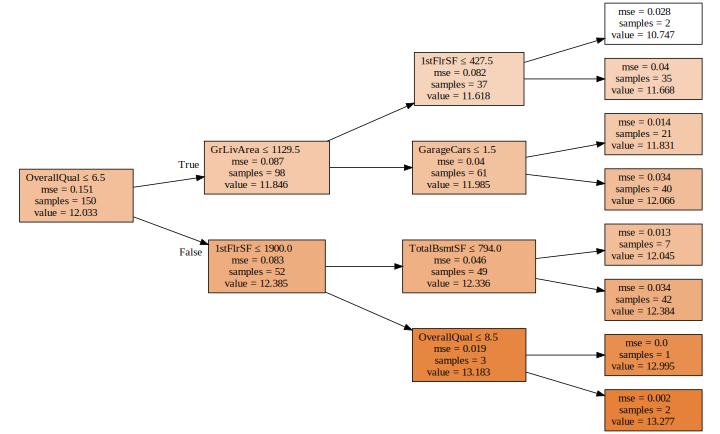

In [24]:
draw_tree(m.estimators_[0], df_trn, precision=3)

In [25]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[3.8756104457853255e-05, 0.21678724173924302, 0.9999999900818903, 0.7086540050965144]


The R^2 for the training model has improved but the R^2 for the validation set has become worse. Bagging technique might improve the R^2.

# Bagginng

Bagging is an ensemble technique mainly used to reduce the variance of our predictions by combining the result of multiple classifiers modelled on different sub-samples of the same data set.

In [26]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

/home/mendu/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.07676457551788333, 0.18268655142056198, 0.9610891807235966, 0.7931027261962796]


In [27]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_]) # This is an array of predctions from 10 trees 
preds[:,0], np.mean(preds[:,0]), y_valid[0] 

(array([11.8494 , 12.0137 , 12.28765, 11.98293, 12.07197, 11.84931, 11.92437, 11.8494 , 11.8494 , 12.19349]),
 11.987162015341104,
 11.960811288962345)

The mean value of the predictions of 10 trees obtained by bagging technique is **11.98**, and the corresponding actual value is **11.96**.

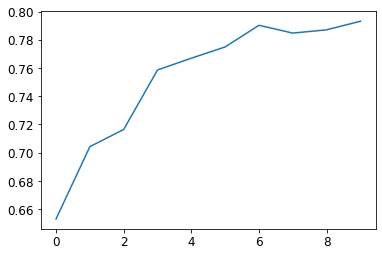

In [28]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

The graph suggests that adding more trees might improve the model.

In [29]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.07262045073503673, 0.17288994713215006, 0.9651769705755783, 0.8146975779947792]


In [30]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.06078265070734595, 0.17642327125609666, 0.9756046001543127, 0.8070461920024465]


In [31]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.06174760193856009, 0.16994668346799952, 0.9748238764544569, 0.8209530199695174]


By setting the 'oob_score' to True we can obtain the Out-of-bag score of the model. The oob_score can determine if the model is overfitting. It can do so with a small amount of data, without requiring a validation set.


In [32]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.06312739890817169, 0.1667278620190789, 0.9736861460597308, 0.8276711558244463, 0.7943593897373966]


There is difference between the oob score and the R^2 of the validation set, the model is still overfitting. It might also be due to the time difference in the validation set and training set.

## Reducing over-fitting

In [33]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

For each tree, for the bagging process, a different random subset is selected from the entire dataset. This way each individual tree is built on a random sample. 

In [34]:
set_rf_samples(400)

In [35]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

/home/mendu/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 93.8 ms, sys: 15.6 ms, total: 109 ms
Wall time: 125 ms
[0.12368255208622672, 0.17336197617671673, 0.9038608636303729, 0.8136843608511816, 0.8368253292017044]


In [36]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11077197287603663, 0.15830038642640087, 0.9228842437578804, 0.8446520370279393, 0.8577470587930469]


###  Using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.

In [37]:
reset_rf_samples()

In [38]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [39]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.05259749353366027, 0.15585065777688467, 0.9826134490185245, 0.8494229127288249, 0.868763393325635]


In [40]:
t=m.estimators_[0].tree_

In [41]:
dectree_max_depth(t)

25

In [42]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.0908407648297766, 0.1558100474248372, 0.9481385201907393, 0.8495013749170951, 0.8609615948175847]


In [43]:
t=m.estimators_[0].tree_

In [44]:
dectree_max_depth(t)

15

In [45]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07376944549255682, 0.15645933176499868, 0.9657991910511424, 0.8482444598245604, 0.8639306389283061]


In [46]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07657683682193554, 0.1406907228937869, 0.9631465469334131, 0.8772920967960427, 0.8704978759820814]


In [47]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=None, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07345624140678017, 0.15469416446892917, 0.9660889883603078, 0.8516493426479881, 0.8652584959873242]


RMSE of the validation set with n_estimators set as 40 is 0.1406

# Interpretation of Randon Forest Model

Interpreting a Random Forest can be a powerful tool. We can calculate the confidence intervals of the trees and understand how accurate they are. Another thing we can do is identifying which features are important.

In [48]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [49]:
df_raw

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,YearRemodAddDay,YearRemodAddDayofweek,YearRemodAddDayofyear,YearRemodAddIs_month_end,YearRemodAddIs_month_start,YearRemodAddIs_quarter_end,YearRemodAddIs_quarter_start,YearRemodAddIs_year_end,YearRemodAddIs_year_start,YearRemodAddElapsed
0,1,60,3,65.0,8450,1,-1,0,3,0,...,1,2,1,False,True,False,True,False,True,1041379200
1,2,20,3,80.0,9600,1,-1,0,3,0,...,1,3,1,False,True,False,True,False,True,189302400
2,3,60,3,68.0,11250,1,-1,1,3,0,...,1,1,1,False,True,False,True,False,True,1009843200
3,4,70,3,60.0,9550,1,-1,1,3,0,...,1,3,1,False,True,False,True,False,True,0
4,5,60,3,84.0,14260,1,-1,1,3,0,...,1,5,1,False,True,False,True,False,True,946684800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,3,62.0,7917,1,-1,0,3,0,...,1,5,1,False,True,False,True,False,True,946684800
1456,1457,20,3,85.0,13175,1,-1,0,3,0,...,1,4,1,False,True,False,True,False,True,567993600
1457,1458,70,3,66.0,9042,1,-1,0,3,0,...,1,6,1,False,True,False,True,False,True,1136073600
1458,1459,20,3,68.0,9717,1,-1,0,3,0,...,1,0,1,False,True,False,True,False,True,820454400


In [50]:
set_rf_samples(400)

In [51]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11798515659586872, 0.1486768020047893, 0.9125140953277723, 0.8629660946971605, 0.862791243065778]


In [52]:
def get_preds(t): return t.predict(X_valid)
preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0]) 

(11.913328939897772, 0.2135658372777842)

The standard deviation for this model is low (aroud 0.21) and that can imply that the model's predictions are fairly accurate.

## Feature Importance

Feature importance is being done by randomly shuffling a column, each column one at a time, then seeing how accurate the pre-trained model is when you pass that in all the data as before but with one column shuffled. And we compare the R^2 of the previous model and the model with one of it's colummns shuffled. The features with the higher difference in the R^2 have higher influence on the model.

In [53]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
17,OverallQual,0.286079
44,GrLivArea,0.111759
90,YearBuiltElapsed,0.071542
25,ExterQual,0.067981
78,YearBuiltYear,0.058523
51,KitchenQual,0.047201
36,TotalBsmtSF,0.040285
59,GarageCars,0.037601
41,1stFlrSF,0.034667
60,GarageArea,0.026624


rf_feat_importance is part of Fast.ai library which takes a model m and dataframe df_trn and it will give you back a Pandas dataframe showing you in order of importance how important each column was.

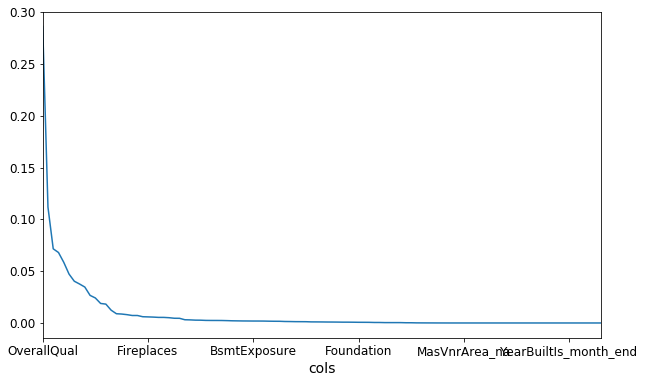

In [54]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False); #plotting the six most important features

In [55]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

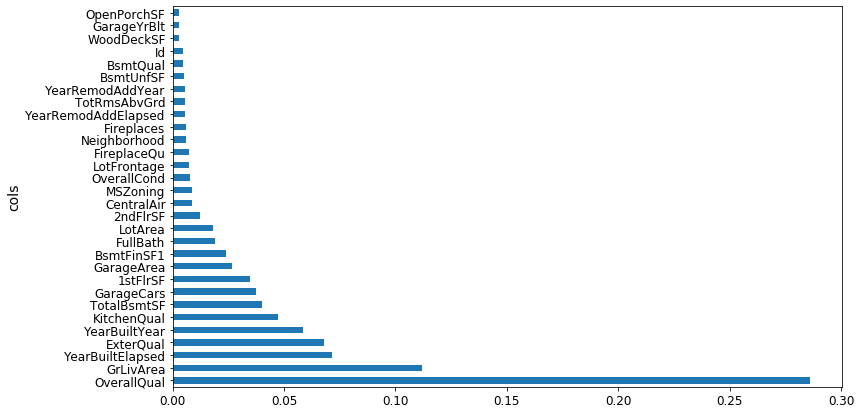

In [56]:
plot_fi(fi[:30]); # plotting the 30 most important features

In [57]:
to_keep = fi[fi.imp>0.005].cols; # the variable to_keep contains all the features whose importance is higher than 0.005
len(to_keep) 

25

In [58]:
df_keep = df_trn[to_keep].copy() # making a duplicate dataset with just the important features
X_train, X_valid = split_vals(df_keep, n_trn)

In [59]:
# making a model with the new dataset
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11915950885442694, 0.14580276432383565, 0.9107638654730263, 0.8682128309765634, 0.8643084302510978]


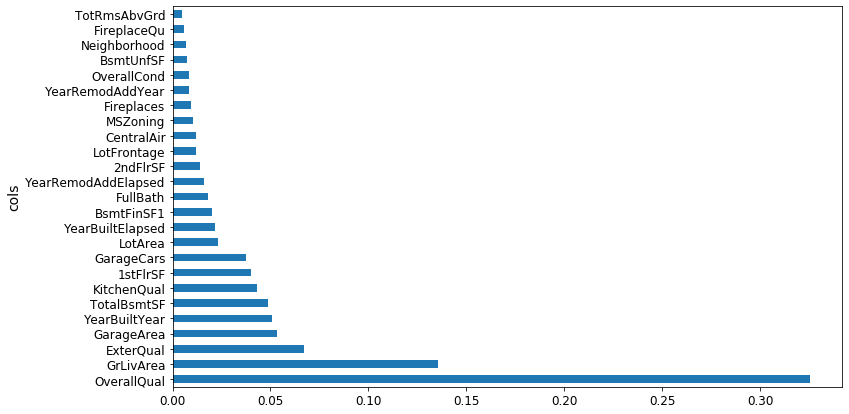

In [60]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [61]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12151357628808511, 0.15710607976659677, 0.9072032115465094, 0.8469872584152001, 0.8537159739600853]


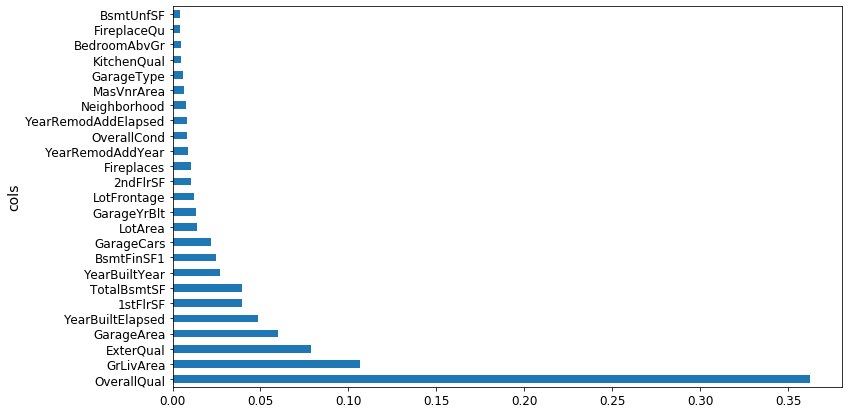

In [62]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

## Removing Redundant features using cluster analysis

There seems to be variables that have similar meanings, they might be measuring the same or similar things. Removing redundant features can be helpful, as it can make the Random Forest slightly better. The way I do that is to do something called “dendrogram”. And it is kind of hierarchical clustering. Cluster analysis is something where you are trying to look at objects, they can be either rows in the dataset or columns and find which ones are similar to each other. In hierarchical or agglomerated clustering, we look at every pair of objects and say which two objects are the closest. We then take the closest pair, delete them, and replace them with the midpoint of the two. Then repeat that again and again. 

In [63]:
from scipy.cluster import hierarchy as hc

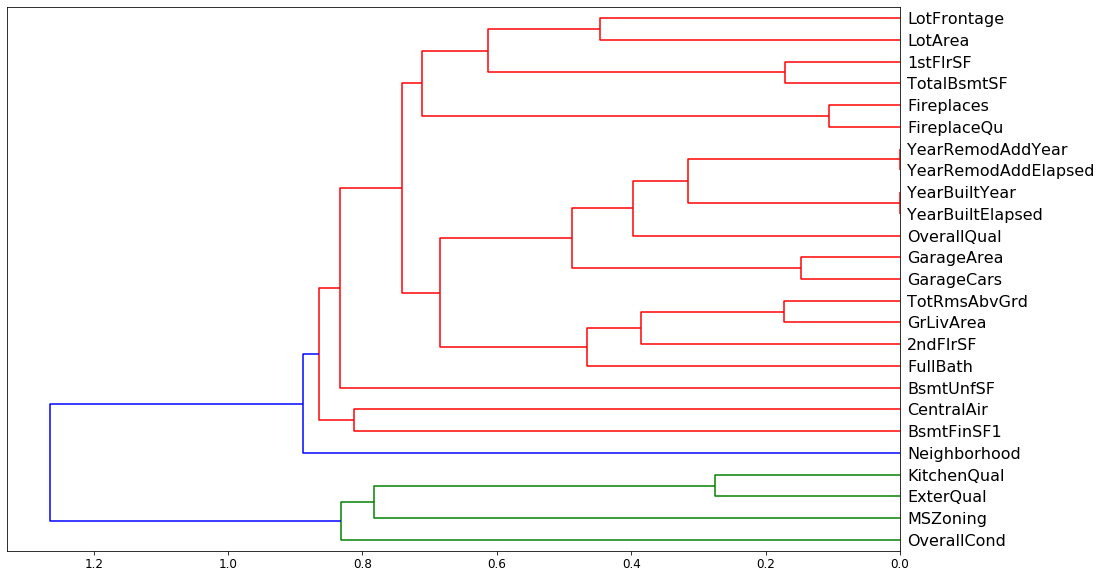

In [64]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

All the independent variables seem to have formed two major clusters.

In [65]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [66]:
get_oob(df_keep)

0.8517115275866274

In [67]:
for c in ('YearRemodAddYear','YearRemodAddElapsed','YearBuiltYear','YearBuiltElapsed'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

YearRemodAddYear 0.8565575815308457
YearRemodAddElapsed 0.8569353894989971
YearBuiltYear 0.8602787540147614
YearBuiltElapsed 0.8545910461498367


In [68]:
to_drop = ['YearRemodAddYear', 'YearBuiltElapsed']
get_oob(df_keep.drop(to_drop, axis=1))


0.8583950278582291

After selecting the important columns and dropping the redundant columns, From here we will be using only these set of columns.

In [69]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [70]:
np.save('tmp/new_cols.npy', np.array(df_keep.columns))

In [71]:
keep_cols = np.load('tmp/new_cols.npy', allow_pickle = True)

In [72]:
df_keep = df_trn[keep_cols]

Trying this model on the complete Dataset.

In [73]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12143625173393073, 0.15480282280117869, 0.9073212755106523, 0.8514408642440096, 0.8651362365366375]


In [74]:
from pdpbox import pdp
from plotnine import *

In [75]:
set_rf_samples(400)

By setting max_n_cat = 7 all the categorical variable with upto seven categories in them will be one hot encoded.

In [76]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

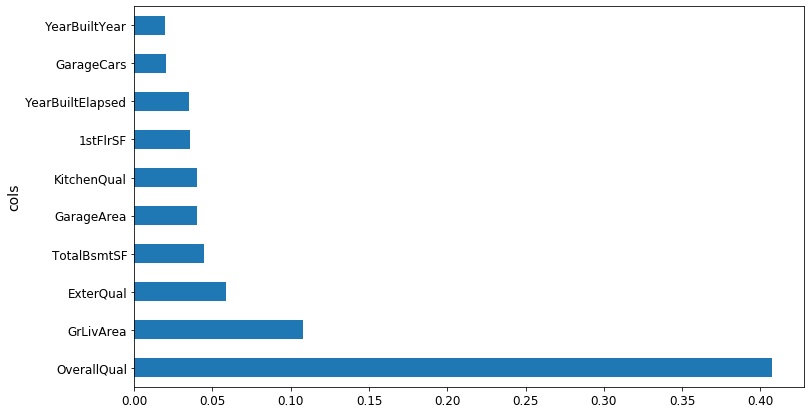

In [77]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

The feature OverallQual is the most important feature. By plotting it against the dependent variable we can look at the relationship between them. Usually for bigger dataset a sample is plotted but since the df_raw dataframe has only 1460 rows it won't be a problem to plot the entire dataframe. The method here is 'loess' which stands for locally weighted regression.

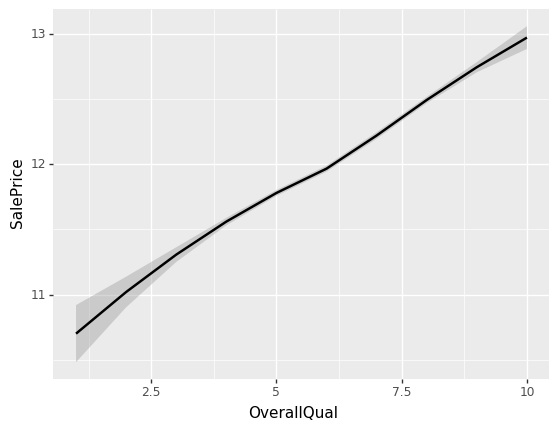

<ggplot: (-9223363304052830229)>

In [78]:
ggplot(data = df_raw, mapping = aes(x= 'OverallQual',y = 'SalePrice')) + stat_smooth(se=True, method= 'loess')

There seems to be a linear and positive relationship between OverallQual and SalePrice. 

In [79]:
x = get_sample(X_train, 500)

In [80]:
import matplotlib.pyplot as plt
from matplotlib import rc

In [81]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

This is a partial dependence plpt(PDP), with a dataset of 500 rows. Every column remains the same, except the one we are interested in which is the OverallQual column. We replace the OverallQual column with 1 and keep the rest of the data exactly the same. We then run the model and predict the SalePrice and we plot it. We do the same for the rest of the values of OverallQual. Each thin blue line represents a row from the sample of 500. The thick black line is the average of the PDP.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


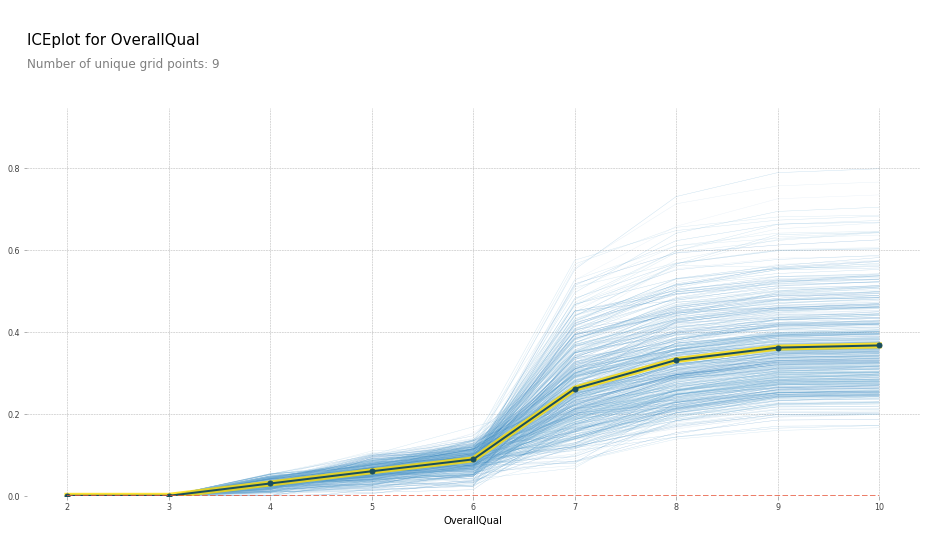

In [82]:
plot_pdp('OverallQual')

These are the five most commonly found trends in the PDP. The thick black line is still the same as the PDP as it is the average.

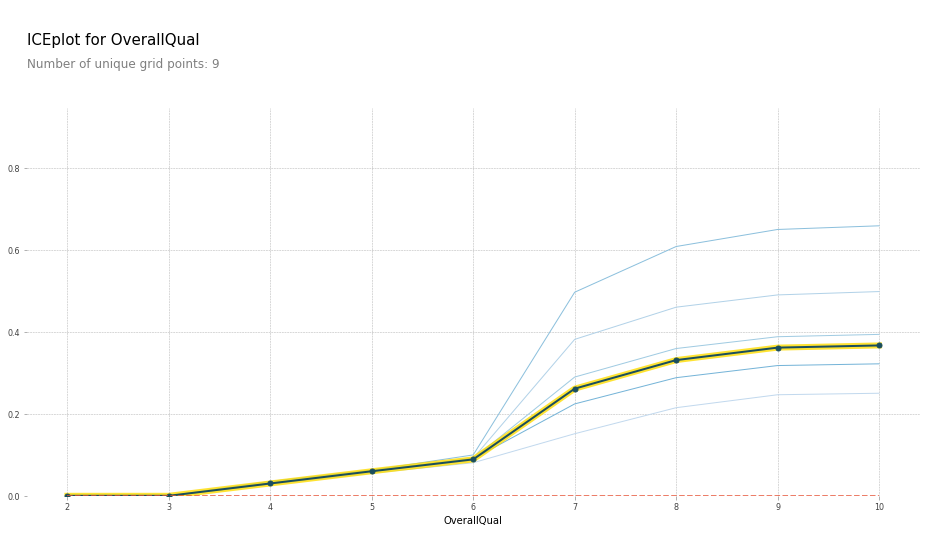

In [83]:
plot_pdp('OverallQual', clusters=5)

In [84]:
df_keep['age'] = df_raw['age'] = df_raw.YrSold-df_raw.YearBuiltYear # Adding an age column 

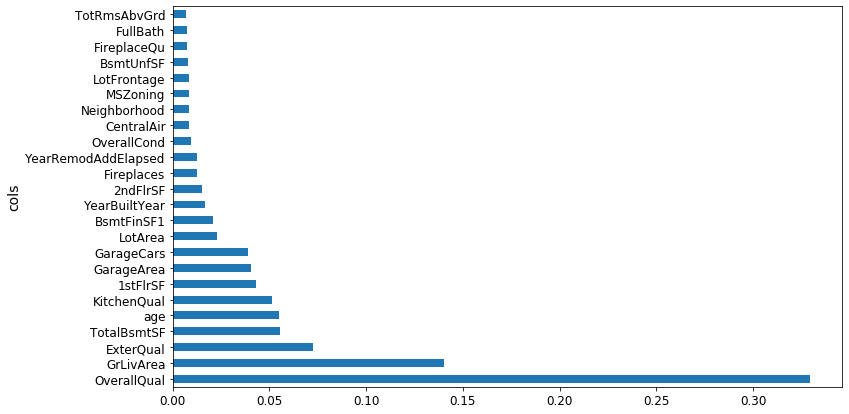

In [85]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

In [86]:
from treeinterpreter import treeinterpreter as ti

In [87]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [88]:
row = X_valid.values[None,0]; row # Here are all the columns in row zero

array([[ 6.00000e+00,  1.47800e+03,  2.00000e+00,  1.95700e+03,  2.00000e+00,  1.47800e+03,  2.00000e+00,
         1.47800e+03,  4.42000e+02,  1.89000e+02,  1.00000e+00,  8.40000e+03,  0.00000e+00,  1.00000e+00,
         3.00000e+00,  3.00000e+00,  7.00000e+01,  1.00000e+00,  1.20000e+01,  2.00000e+00, -4.10227e+08,
         6.00000e+00,  6.28000e+02,  5.20000e+01]])

In [89]:
prediction, bias, contributions = ti.predict(m, row)

Predictions stores the prediction from the Random Forest. Bias is the average SalePrice of the entire dataset and contributions is a column which stores the value to split by(i.e. the predictor), and how much it changed the predicted value. 

In [90]:
prediction[0], bias[0]

(array([11.92366]), 12.027484966539324)

In [91]:
idxs = np.argsort(contributions[0])

In [92]:
#This is a list of the features, the actual value and the contributions of the first row
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('OverallQual', 6.0, -0.09862943727107014),
 ('ExterQual', 2.0, -0.02963702767635512),
 ('YearRemodAddElapsed', -410227200.0, -0.02915745686962943),
 ('KitchenQual', 2.0, -0.029146966295300468),
 ('age', 52.0, -0.025006888232598355),
 ('BsmtFinSF1', 189.0, -0.01925812487331031),
 ('LotArea', 8400.0, -0.018463841610279717),
 ('FullBath', 1.0, -0.014483056231666503),
 ('OverallCond', 3.0, -0.013354525441311615),
 ('YearBuiltYear', 1957.0, -0.010157197802639573),
 ('2ndFlrSF', 0.0, -0.00922789321317441),
 ('Neighborhood', 12.0, -0.0029760210192832483),
 ('TotRmsAbvGrd', 6.0, -0.00034631746659501416),
 ('CentralAir', 1.0, 0.0005190369199010725),
 ('BsmtUnfSF', 628.0, 0.0012919123683597712),
 ('LotFrontage', 70.0, 0.00782403422264406),
 ('GarageArea', 442.0, 0.00972259952706076),
 ('MSZoning', 3.0, 0.010911535862142196),
 ('TotalBsmtSF', 1478.0, 0.013779199287200417),
 ('FireplaceQu', 1.0, 0.014244282111777196),
 ('GarageCars', 2.0, 0.018845448590602797),
 ('1stFlrSF', 1478.0, 0.0219599302

In [93]:
contributions[0].sum() #The sum of all the contributions

-0.10382626324749838

**Contributions** is a useful tool to understand which specific feature has most influenced a prediction.

### Extrapolation

In [104]:
#Making a new dataset where now the dependent variable being considered is 'is_valid' 
#Which tells us if the data is a part of the validation set or not
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [105]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9041095890410958

Since the R^2 between the dataset and the 'is_valid' variable is high, we can conculde that is not a random sample.

In [106]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
11,LotArea,0.106673
1,GrLivArea,0.088959
7,1stFlrSF,0.086980
8,GarageArea,0.076492
5,TotalBsmtSF,0.073159
22,BsmtUnfSF,0.069760
23,age,0.065255
9,BsmtFinSF1,0.062844
16,LotFrontage,0.056944
20,YearRemodAddElapsed,0.056275


In [107]:
feats =['GrLivArea','1stFlrSF','LotArea']
#These three features are the most important feature for this dataset and to predicting whether something is in the dataset or not

In [108]:
(X_train[feats]/1000).describe()

,GrLivArea,1stFlrSF,LotArea
count,1320.000000,1320.000000,1320.000000
mean,1.514167,1.163248,10.562487
std,0.525768,0.386685,10.318517
min,0.334000,0.334000,1.300000
25%,1.129500,0.884000,7.590000
50%,1.456000,1.088000,9.485000
75%,1.768000,1.390250,11.616000
max,5.642000,4.692000,215.245000


In [109]:
(X_valid[feats]/1000).describe()

,GrLivArea,1stFlrSF,LotArea
count,140.000000,140.000000,140.000000
mean,1.527686,1.156771,10.086329
std,0.524477,0.387006,5.930543
min,0.630000,0.483000,1.533000
25%,1.136500,0.864000,7.200000
50%,1.519000,1.065000,9.426000
75%,1.844000,1.417500,11.431500
max,3.238000,2.633000,57.200000


In [110]:
x.drop(feats, axis=1, inplace=True) #Let's drop these features and see whether we are still able to predict if something is in the validation set

In [111]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9041095890410958

Since the R^2 didn't decrease much from before we can still predict the whether the data is in the dataset or not. But since the importance of the features is quite similar, it has not effected the R^2.

In [113]:
fi = rf_feat_importance(m, x); fi[:10] #Now other features have come up on the list

,cols,imp
19,BsmtUnfSF,0.129016
4,TotalBsmtSF,0.124671
6,GarageArea,0.106436
20,age,0.087558
7,BsmtFinSF1,0.082254
13,LotFrontage,0.072686
17,YearRemodAddElapsed,0.070128
2,YearBuiltYear,0.059400
18,TotRmsAbvGrd,0.044483
9,2ndFlrSF,0.043694


In [114]:
set_rf_samples(400)

In [115]:
feats =['BsmtUnfSF','TotalBsmtSF','YearRemodAddElapsed','age','YearBuiltYear','GarageArea']

In [116]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11838563019636662, 0.14955500690094298, 0.9119191856502826, 0.8613424483882087, 0.8646384550319108]


In [117]:
#This loop goes through each feature and drop each one, one at a time, retrain a new random forest, and print out the score.
#Before doing any of that, the score was 0.8613 for validation, 0.8946 for OOB.
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)


BsmtUnfSF
[0.12064944919765622, 0.14508377112720944, 0.9085183418801224, 0.8695093831958333, 0.8660091101789945]
TotalBsmtSF
[0.12291421938140612, 0.14414318041083032, 0.9050516121401065, 0.8711958626741345, 0.8616315622674989]
YearRemodAddElapsed
[0.11954753622567042, 0.14740509391326498, 0.9101817475932475, 0.8653003099384159, 0.8670758108954422]
age
[0.12072018903966539, 0.1512072564269326, 0.9084110343829417, 0.8582618109205193, 0.865784000570082]
YearBuiltYear
[0.11954949411562435, 0.14770295019708096, 0.9101788055720291, 0.8647553941048659, 0.8674530212873849]
GarageArea
[0.117089978377101, 0.14989498019482356, 0.9138366070836703, 0.8607113301735055, 0.8687386071772468]


In [119]:
reset_rf_samples()

In [120]:
df_subs = df_keep.drop(['TotalBsmtSF','BsmtUnfSF','YearRemodAddElapsed'], axis=1) 
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.08244348921312952, 0.14100165908372927, 0.9572834599624244, 0.876749111601867, 0.874879028978599]


In [121]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

## Final Model

In [122]:
cols = X_train.columns

In [123]:
m = RandomForestRegressor(n_estimators=80, max_features=0.5, n_jobs=-1, oob_score=True)#Final model
m.fit(X_train, y_train)
print_score(m)

[0.05218713729883777, 0.13794658230945625, 0.9828836842473516, 0.8820321938164831, 0.877823752251893]


The RMSE is 0.1379 and the R^2 for the validation score is 0.882

In [124]:
df_test = pd.read_csv('Housing_test.csv', low_memory=False,
                     parse_dates=["YearBuilt", "YearRemodAdd"]) #importing the test set
df_test.shape

(1459, 80)

In [125]:
add_datepart(df_test, 'YearBuilt')
add_datepart(df_test, 'YearRemodAdd')

In [126]:
df_test['age'] = df_test.YrSold-df_test.YearBuiltYear #adding the same column that was added to the 

In [127]:
train_cats(df_test)

In [128]:
apply_cats(df = df_test, trn= df_trn2) 
#apply_cats is used on the test set to make sure that the mappings are the same throughout the training set and test set

In [129]:
df_cat(df_test)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,YearRemodAddDayofweek,YearRemodAddDayofyear,YearRemodAddIs_month_end,YearRemodAddIs_month_start,YearRemodAddIs_quarter_end,YearRemodAddIs_quarter_start,YearRemodAddIs_year_end,YearRemodAddIs_year_start,YearRemodAddElapsed,age
0,1461,20,2,80.0,11622,1,-1,0,3,0,...,6,1,False,True,False,True,False,True,-283996800,49
1,1462,20,3,81.0,14267,1,-1,1,3,0,...,2,1,False,True,False,True,False,True,-378691200,52
2,1463,60,3,74.0,13830,1,-1,1,3,0,...,3,1,False,True,False,True,False,True,883612800,13
3,1464,60,3,78.0,9978,1,-1,1,3,0,...,3,1,False,True,False,True,False,True,883612800,12
4,1465,120,3,43.0,5005,1,-1,1,1,0,...,2,1,False,True,False,True,False,True,694224000,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,4,21.0,1936,1,-1,0,3,0,...,3,1,False,True,False,True,False,True,0,36
1455,2916,160,4,21.0,1894,1,-1,0,3,0,...,3,1,False,True,False,True,False,True,0,36
1456,2917,20,3,160.0,20000,1,-1,0,3,0,...,0,1,False,True,False,True,False,True,820454400,46
1457,2918,85,3,62.0,10441,1,-1,0,3,0,...,2,1,False,True,False,True,False,True,694224000,14


In [130]:
X_test,_,nas = proc_df(df_test, na_dict=nas) 

In [131]:
X_test1 = X_test[cols].copy()

In [132]:
prediction =m.predict(X_test1)

In [133]:
prediction = np.exp(prediction) #Taking the exponential of the predictions since the 'SalePrice' is in log measures

In [134]:
#All the predictions for the test set are stored in the csv file 'submission.csv'
submission = pd.DataFrame()
submission['Id']= X_test['Id']
submission['SalePrice']=prediction
submission.to_csv('submission.csv',index=False)